In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import pickle
import scipy
import os
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from copy import deepcopy
from sklearn.utils import shuffle
from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from warnings import simplefilter
import warnings
# ignore all future warnings
from sklearn.exceptions import DataConversionWarning, FitFailedWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.formula.api import ols
display(HTML("<style>.container { width:85% !important; }</style>"))
sns.set_context(rc={'lines.linewidth': 2.5,
                    'axes.labelsize': 25,
                    'axes.titlesize': 19.200000000000003,
                    'font.size': 25,
                    'xtick.major.width': 8,
                    'ytick.major.width': 8,
                    'xtick.major.size':6,
                    'ytick.major.size':6,
                    'axes.linewidth':4})

Inits

In [7]:
full_data = pd.read_pickle('fully_labeled_traces_feats3_071924.pickle')
# region and indexing-related variables / functions
region_ids = ['PrL (E)', 'PrL (I)', 'vLS (E)', 'vLS (I)', 'POA (E)', 'POA (I)',
       'BNST (E)', 'BNST (I)', 'AH (E)', 'AH (I)', 'MeA (E)', 'MeA (I)',
       'VMH (E)', 'VMH (I)', 'PAG (E)', 'PAG (I)', 'PMv (E)', 'PMv (I)', 'LHb (E)', 'LHb (I)',
       'PA (E)', 'PA (I)', 'NAc (DA)'] # populations
indices = {val: idx for idx, val in enumerate(region_ids)} # dictionary with IDs for remapping
agg_animals = ['3095', '3096', '3097', '4013', '4014', '4015', '4016', '91R2', '30L', '30B', '30R2', '29L']
obs_animals = ['30R2', '29L', '86L', '87L2', '927R', '927L', '933R']
non_animals = ['87R2', '87L', '87B', '86L2', '583L2', '583B']
animals = np.concatenate([agg_animals, obs_animals, non_animals])

In [3]:
full_data['3095_d1_balbc_t1'].head()

,PrL (E),PrL (I),vLS (E),vLS (I),POA (E),POA (I),BNST (E),BNST (I),AH (E),AH (I),...,PAG (I),PMv (E),PMv (I),LHb (E),LHb (I),PA (E),PA (I),NAc (DA),unsupervised labels,attack labels
0,-0.445144,-0.917106,-0.796197,-0.779305,-0.613402,-0.484051,NaN,NaN,-0.191755,-0.905187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.647004,10.0,0
1,-0.605299,-1.043437,-0.898095,-0.798017,-0.660480,-0.632012,NaN,NaN,-0.385685,-0.942072,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.849862,10.0,0
2,-0.737057,-1.129971,-0.976553,-0.836116,-0.730437,-0.753815,NaN,NaN,-0.554598,-0.977626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.007445,10.0,0
3,-0.840632,-1.177196,-1.031742,-0.887316,-0.812514,-0.849883,NaN,NaN,-0.695823,-1.009212,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.122185,10.0,0
4,-0.916240,-1.185599,-1.063835,-0.945330,-0.895955,-0.920637,NaN,NaN,-0.806685,-1.034196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.196516,10.0,0


In [4]:
def format4analysis(full_data, animal_ID, binary_labels='attack labels', exp='aggression'):

    sessions = list(full_data.keys())
    region_index, region_id = pd.factorize(region_ids)
    epochs = [[0, 3], [3, 6], [6, 9], [9, 12], [12, 15], [15, 18], [18, 21], [21,24], [24, 28]]
    f = np.max([full_data[session].shape[0] for session in sessions])

    traces_lib = np.empty((f, len(region_index), 27))
    traces_lib[:] = np.nan

    # package recordings into traces_lib array

    if exp == 'aggression':
        sessions = [x for x in sessions if '_balbc_' in x or '_mCD1_' in x]
    elif exp == 'observation':
        sessions = [x for x in sessions if '_obs_' in x or '_OBSmCD1_' in x]
    elif exp == 'nonsocial':
        sessions = [x for x in sessions if '_toy_' in x or '_toyCD1_' in x]
    else:
        raise Exception("Please specify experience type as 'aggression' or 'observation'.")

    for i, sesh in enumerate([x for x in sessions if animal_ID in x]):

        # format traces from each session to fit the big nan array above
        s = full_data[sesh]
        not_na_cols = s.columns[s.notna().all()].tolist()
        if s.shape[0] < f:
            nan_pad = np.zeros((f-s.shape[0], s.shape[1]))
            nan_pad[:] = np.nan
            nan_pad = pd.DataFrame(nan_pad, columns=s.columns)
            s = pd.concat([s, nan_pad], axis=0)

        # copy columns at specific locations
        for idx, roi in zip(region_index, region_id):
            try: 
                traces_lib[:, idx, i] = s[roi]
            except KeyError:
                traces_lib[:, idx, i] = np.nan

    # separate into epochs

    d1 = traces_lib[:, :, epochs[0][0]:epochs[0][1]]
    d2 = traces_lib[:, :, epochs[1][0]:epochs[1][1]]
    d3 = traces_lib[:, :, epochs[2][0]:epochs[2][1]]
    d4 = traces_lib[:, :, epochs[3][0]:epochs[3][1]]
    d5 = traces_lib[:, :, epochs[4][0]:epochs[4][1]]
    d6 = traces_lib[: ,:, epochs[5][0]:epochs[5][1]]
    d7 = traces_lib[: ,:, epochs[6][0]:epochs[6][1]]
    d8 = traces_lib[: ,:, epochs[7][0]:epochs[7][1]]
    d9 = traces_lib[: ,:, epochs[8][0]:epochs[8][1]]
    trial_comps = [d1, d2, d3, d4, d5, d6, d7, d8, d9] 

    return trial_comps, not_na_cols

def produce_XY(epoch, orig_idx):
    
    filtered_sessions = epoch[~np.isnan(epoch).all(axis=1)]
    
    X_idxs = [x for x in np.arange(filtered_sessions.shape[1]) if orig_idx != x]
    X = filtered_sessions[:, X_idxs]
    orig_X = X.copy()
    if np.isnan(X).any(axis=0).any(): # remove columns with nan
        has_nan = np.isnan(X).any(axis=0)
        X = X[:, ~has_nan]
    y_init = filtered_sessions[:, orig_idx]
    y = y_init.reshape(-1,1)

    return X, y

def fit_ridge(X, y, verbose=0):

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

    # Define the hyperparameters to search over
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

    # Define ridge regression model
    model = Ridge(fit_intercept=True, normalize=True)

    # Use GridSearchCV to perform a grid search with cross-validation
    # grid_search = GridSearchCV(model, param_grid, cv=3, scoring=make_scorer(r2_score))
    grid_search = GridSearchCV(model, param_grid, cv=None, scoring=make_scorer(r2_score))

    # Fit the grid search to the training data
    grid_search.fit(X, y)

    # Get the best hyperparameters found by the grid search
    best_params = grid_search.best_params_
    if verbose == 1:
        print('Best hyperparameters:', grid_search.best_params_)
        print('Best score:', grid_search.best_score_)

    # Train a new SVM classifier using the best hyperparameters
    best_model = Ridge(**best_params, fit_intercept=True, normalize=True) # rbf
    
    return X_train, X_test, y_train, y_test, best_model, grid_search.best_score_

def string_mapper(string_list, index):
    """
    Maps a list of strings to indices in ascending order, and returns a function to retrieve the string for a given index.
    """
    index_map = {i: string_list[i] for i in range(len(string_list))}
    
    def get_string(index):
        """
        Returns the string corresponding to the given index in the mapping.
        """
        return index_map[index]
    
    return get_string(index)

def format_weights(fold_weights, global_weights, rois):
    
    if fold_weights.shape[0] < global_weights.shape[0]:
        truncated_weights = np.zeros((global_weights.shape[0]))
        pres_idxs, miss_idxs = get_indices(rois)
        truncated_weights[pres_idxs] = np.array(np.mean(fold_weights, axis=1))
        truncated_weights[miss_idxs] = np.nan
        return truncated_weights
    else:
        return np.mean(fold_weights, axis=1)
    
def get_indices(partial_list):
    present_indices = [indices[val] for val in partial_list if val in indices]
    not_present = [val for val in np.arange(len(region_ids)) if val not in present_indices]
    return present_indices, not_present
    
def add_nan_values(matrix, rois, n_features=22):
    
    if len(rois) < n_features: 
        
        # Get roi indices
        pres_idxs, miss_idxs = get_indices(rois)
        # Create a copy of the original matrix to avoid modifying it
        matrix_copy = matrix.copy()
        # Create a 1D boolean mask that indicates where to add NaN values
        nan_mask = np.zeros(matrix_copy.shape[2], dtype=bool)
        print(miss_idxs)
        nan_mask[miss_idxs] = True
        # Add NaN values to the matrix
        matrix_copy = np.insert(matrix_copy, miss_idxs, np.nan, axis=2)
                
        return matrix_copy
    
    else:
        
        return matrix
    
def permutation_test(model, X_train, y_train, X_test, y_test, coefficients, rois, region_idx, n_permutations=100):
    
    shuf_model = deepcopy(model)
    max_coefs = np.zeros((n_permutations, 22))
    shuf_kos = np.zeros((n_permutations, 22))
    
    # Perform the permutations
    for i in range(n_permutations):
        
        # Shuffle the target variable (y)
        y_shuffled = shuffle(y_train)

        # Fit the model to the shuffled data
        shuf_model.fit(X_train, y_shuffled)
        shuf_best_score = r2_score(y_test, shuf_model.predict(X_test))

        # Store the maximum coefficient from the shuffled data
        max_coefs[i, :] = format_shuffled_weights(shuf_model.coef_, max_coefs, rois, region_idx)
        
        # Do knockout on shuffled model
        shuf_knockouts = np.zeros((shuf_model.coef_.shape[1]))
        for shuf_idx in np.arange(X_train.shape[1]):
            shuf_ko_model = deepcopy(shuf_model)
            new_shuf_coef=shuf_ko_model.coef_.copy()
            new_shuf_coef[:, shuf_idx] = 0.
            shuf_ko_model.coef_ = new_shuf_coef
            shuf_y_pred = shuf_ko_model.predict(X_test)
            shuf_ko_score = r2_score(y_test, shuf_y_pred)
            if shuf_ko_score < 0:
                shuf_ko_score = 0
            shuf_knockout_score_difference = shuf_best_score - shuf_ko_score
            if shuf_knockout_score_difference < 0:
                shuf_knockout_score_difference = 0
            shuf_knockouts[shuf_idx] = shuf_knockout_score_difference
        shuf_knockouts = shuf_knockouts.reshape((1, shuf_model.coef_.shape[1]))
            
        shuf_kos[i, :] = format_shuffled_weights(shuf_knockouts, shuf_kos, rois, region_idx)
        
    return max_coefs, shuf_kos

## Cluster by cluster regressions - E vs I

Here we're running a separate model for each cluster for each day. Mode is OLS from statsmodels.

#### Local E vs I:

In [9]:
def grab_cluster_idxs(full_data, animal_ID, exp='aggression'):

    sessions = list(full_data.keys())

    if exp == 'aggression':
        sessions = [x for x in sessions if '_balbc_' in x or '_mCD1_' in x if animal_ID in x]
    elif exp == 'observation':
        sessions = [x for x in sessions if '_obs_' in x or '_OBSmCD1_' in x if animal_ID in x]
    elif exp == 'nonsocial':
        sessions = [x for x in sessions if '_toy_' in x or '_toyCD1_' in x if animal_ID in x]
    else:
        raise Exception("Please specify experience type as 'aggression' or 'observation'.")

    unsupervised_labels_4_all = []
    for session in sessions:
        d_labels = full_data[session]['unsupervised labels'].values
        placeholder = np.zeros((len(d_labels), 13))
        for i in np.arange(13):
            cluster_idx = np.where(d_labels==i+1)[0]
            placeholder[cluster_idx, i] = 1
        unsupervised_labels_4_all.append(placeholder)

    return unsupervised_labels_4_all

1. Run models

In [72]:
from tqdm import tqdm
animal_scores_per_cluster = np.zeros((23, 27, 13, len(animals)))
EI_regions = np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

pbar = tqdm(enumerate(animals), total=len(animals))
for a, animal in pbar:
    pbar.set_description('Processing animal %i' % a)
    
    # load animal data
    if a <= 11:
        exp = 'aggression'
    elif a <= 18: 
        exp = 'observation'
    else:
        exp = 'nonsocial'

    trial_comps, rois = format4analysis(full_data, animal, exp=exp)
    rois = rois[:-2]
    norm_indices = [i for i, item in enumerate(region_ids) if item in set(rois)]
    trial_comps = np.concatenate(trial_comps, axis=2)
    cluster_comps = grab_cluster_idxs(full_data, animal, exp=exp)
    
    # create arrays for storage of weights and % drop across epochs
    epoch_scores = np.zeros((trial_comps.shape[1], trial_comps.shape[2], 13))
    epoch_scores[:] = np.nan

    # containers for cross-validated score, weights and knockouts
    
    for e in np.arange(trial_comps.shape[-1]):
        # print('Beginning epoch %i...' % e)
        epoch = trial_comps[:, :, e]
        for region_idx, orig_idx in enumerate(norm_indices):
            if orig_idx in EI_regions:
                X, y = produce_XY(epoch, orig_idx)
                X = X[:, region_idx].reshape(-1,1) # sum 1
                for c in np.arange(cluster_comps[e].shape[1]):
                    cluster_indices = np.where(cluster_comps[e][:, c]==1)[0]
                    if len(cluster_indices) > 80:
                        X_hat = X[cluster_indices, :]
                        y_hat = y[cluster_indices, :]
                        model = sm.OLS(y_hat, X_hat).fit()
                        if best_score<0:
                            best_score=0
                        epoch_scores[orig_idx, e, c] = model.rsquared
                    else:
                        epoch_scores[orig_idx, e, c] = np.nan

    animal_scores_per_cluster[:, :, :, a] = epoch_scores
    
animal_scores_per_cluster = animal_scores_per_cluster[EI_regions, :, :, :]

Processing animal 24: 100%|██████████| 25/25 [01:36<00:00,  3.87s/it]


2. Isolate aggression supercluster scores and make table and run stats

In [268]:
# Gather data
all_tables = {}
new_region_ids = np.array([region_ids[idx].split(' ')[0] for idx in EI_regions])
animals2exclude = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
sessions2exclude = [0, 24] # for NON
behaviors = [1, 2, 3, 7]
supercluster_scores = np.nanmean(animal_scores_per_cluster[:, :, behaviors, :], axis=2)
weights2map = np.transpose(supercluster_scores, [1,0,2])

# Sort into table
all_tables = []
for r, roi in enumerate(new_region_ids):
    table = pd.DataFrame(columns=['cross_day', 'cross_session', 'within_day', 'subject', 'dependent_variable'])
    for animal in np.arange((len(np.concatenate([agg_animals, obs_animals, non_animals]))))[animals2exclude]:
        sample = weights2map[sessions2exclude[0]:sessions2exclude[1], r, animal]
        cross_day_info = np.repeat(np.arange(9), 3)[sessions2exclude[0]:sessions2exclude[1]].astype(float)
        within_day_info = np.tile(np.arange(3), 9)[sessions2exclude[0]:sessions2exclude[1]].astype(float)
        session_info = np.arange(27)[sessions2exclude[0]:sessions2exclude[1]].astype(float)
        subject_info = np.repeat(animal, 27)[sessions2exclude[0]:sessions2exclude[1]]
        if animal<=11:
            group_info = np.repeat(0, 27)[sessions2exclude[0]:sessions2exclude[1]]
        elif animal<=18:
            group_info = np.repeat(1, 27)[sessions2exclude[0]:sessions2exclude[1]]
        else:
            group_info = np.repeat(2, 27)[sessions2exclude[0]:sessions2exclude[1]]
        table = pd.concat([table, pd.DataFrame({'cross_day': cross_day_info, 'cross_session': session_info, 'within_day': within_day_info, 'subject': subject_info, 'exp_group': group_info, 'dependent_variable': sample})])
    all_tables.append(table)

C:\Users\Jorge\AppData\Local\Temp\ipykernel_4796\4065160575.py:10: RuntimeWarning: Mean of empty slice
  supercluster_scores = np.nanmean(animal_scores_per_cluster[:, :, behaviors, :], axis=2)


In [269]:
from statsmodels.stats.anova import AnovaRM
from statsmodels.regression.mixed_linear_model import MixedLM

new_idx = np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18])
norm_idx = (new_idx/2).astype(int)
all_labels = [x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)','') for x in np.array(region_ids)[new_idx]]
agg_decouples = [np.nanmean(weights2map[i:i+3, :, :12], axis=0).reshape(11, 12, 1) for i in np.arange(0, 27, 3)]
agg_decouples = np.concatenate(agg_decouples[:-1], axis=2)
obs_decouples = [np.nanmean(weights2map[i:i+3, :, 12:19], axis=0).reshape(11, 7, 1) for i in np.arange(0, 27, 3)]
obs_decouples = np.concatenate(obs_decouples[:-1], axis=2)
data4stats = [agg_decouples.copy(), obs_decouples.copy()]

p_values = []
for r,roi in enumerate(norm_idx):
    print('############ %s ############' % all_labels[r])
    for i, d in enumerate(data4stats):
        # remove nans
        data2stat = d[roi]
        n_nans = len(np.unique(np.where(np.isnan(data2stat))[0]))
        data2stat = data2stat[~np.isnan(data2stat)].reshape(data2stat.shape[0]-n_nans, data2stat.shape[1])
        
        # package into DF
        df = pd.DataFrame(data2stat.flatten(), columns=['Measurement'])
        df['Subject'] = np.repeat(np.arange(data2stat.shape[0]), 8)
        df['Time'] = np.tile(np.arange(8), data2stat.shape[0])

        # Alternatively perform mixed LM
        model = MixedLM(df['Measurement'], df[['Time']], groups=df['Subject'])
        res = model.fit()

        if i==0:
            descrip = 'AGG'
        else:
            descrip = 'OBS'
        # print('%s p-value = %f' % (descrip, res.anova_table['Pr > F']['Time']))
        print('%s p-value = %f' % (descrip, res.pvalues['Time']))
        p_values.append(res.pvalues['Time'])
        
ascending_idx = (np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18])/2).astype(int)
p_values_AGG = np.array(p_values)[::2]
p_values_OBS = np.array(p_values)[1::2]

C:\Users\Jorge\AppData\Local\Temp\ipykernel_4796\2896768280.py:7: RuntimeWarning: Mean of empty slice
  agg_decouples = [np.nanmean(weights2map[i:i+3, :, :12], axis=0).reshape(11, 12, 1) for i in np.arange(0, 27, 3)]


############ VMH ############
AGG p-value = 0.000007
OBS p-value = 0.598103
############ PMv ############
AGG p-value = 0.000262
OBS p-value = 0.027134
############ AH ############
AGG p-value = 0.016847
OBS p-value = 0.103089
############ POA ############
AGG p-value = 0.042789
OBS p-value = 0.306228
############ MeA ############
AGG p-value = 0.000006
OBS p-value = 0.105579
############ PA ############
AGG p-value = 0.000040
OBS p-value = 0.207982
############ BNST ############
AGG p-value = 0.000009
OBS p-value = 0.842740
############ PAG ############
AGG p-value = 0.250622
OBS p-value = 0.608173
############ vLS ############
AGG p-value = 0.517008
OBS p-value = 0.331300
############ PrL ############
AGG p-value = 0.792124
OBS p-value = 0.080975
############ LHb ############
AGG p-value = 0.291530
OBS p-value = 0.096981


3. Plotz

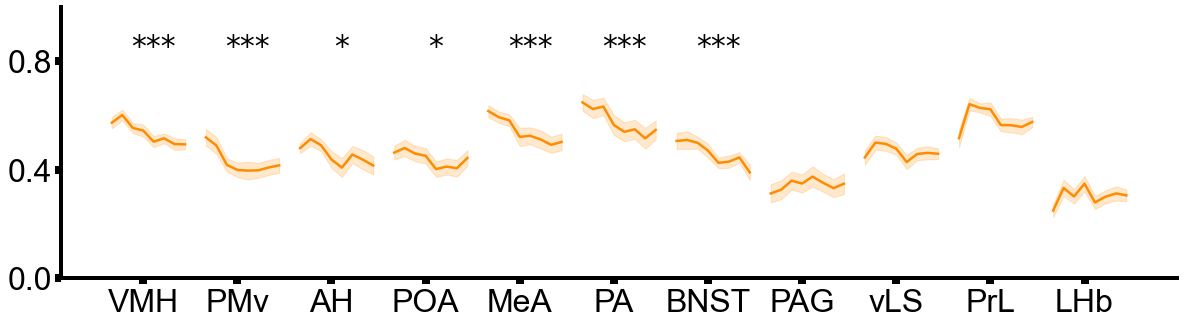

In [270]:
# Plot E-I changes AGG

from scipy.stats import sem

bar_settings = {
    'color': 'white',
    'linewidth': 2.75,
    'capsize': 2.75,
    'error_kw': {'elinewidth': 2.5, 'capsize': 5, 'capthick': 2.5, 'markeredgewidth': 2}}


# Create a figure for the line plots
fig1, ax1 = plt.subplots(figsize=(20, 5))

# Counter for the bar plot positions
bar_counter = 0
factor = 9

ascending_idx = (np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18])/2).astype(int)

indices = []

for t, roi in enumerate([EI_regions[x] for x in ascending_idx]):
    element_at_t = np.array([EI_regions[x] for x in ascending_idx])[t]
    t_hat = next((i for i, element in enumerate(EI_regions) if element == element_at_t), None)
    table = all_tables[t_hat]
    table = table.dropna(axis=0)
    table = table.reset_index(drop=True)


    # Get unique groups
    groups = table['exp_group'].unique()

    # Plot E
    group = 0
    color='darkorange'
    subset = table[table['exp_group'] == group]
    means = subset.groupby('cross_day')['dependent_variable'].mean()
    errors = subset.groupby('cross_day')['dependent_variable'].apply(sem)
    ax1.plot(means.index.values + t*factor, means.values, color=color, linewidth=2.5)
    ax1.fill_between(means.index.values + t*factor, means.values - errors.values, means.values + errors.values, alpha=0.2, color=color)
    indices.append(t*factor)

# Cleaning
labels=[x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)','') for x in np.array(region_ids)[new_idx]]
ax1.set_xticks((np.arange(0, 11*factor, factor)+2)+1, labels, fontsize=32, fontfamily='Arial')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylim(top=1, bottom=0)
ax1.set_yticks(np.arange(0, 1, 0.4));
ax1.set_yticklabels(np.arange(0, 1, 0.4), fontsize=32, fontfamily='Arial');
ax1.set_title('')

# Adding stars
try:
    for p_value, index in zip(p_values_AGG, indices):
        # If the p-value is less than 0.05, add a "*" above the line
        if p_value < 0.06:
            if p_value < 0.001:
                marker='***'
            elif p_value < 0.01:
                marker = '**'
            elif p_value < 0.05:
                marker = '*'
            elif p_value < 0.06:
                marker = '#'
            plt.text(index+4, 0.8, marker, ha='center', va='bottom', fontsize=30, color='black')
except ValueError:
    pass

# Save fig1 as an SVG file
fig1.savefig('.\\figures\\AGG_I2E_supercluster.svg', dpi=300, format='svg')

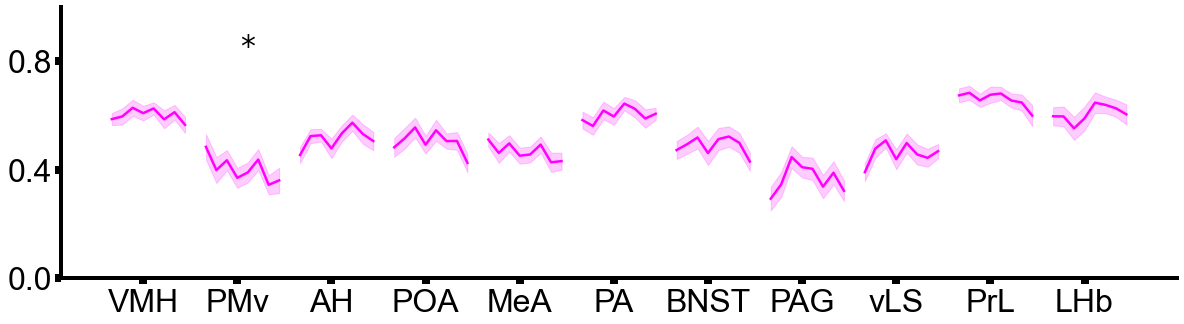

In [271]:
# Plot E-I changes OBS

from scipy.stats import sem

bar_settings = {
    'color': 'white',
    'linewidth': 2.75,
    'capsize': 2.75,
    'error_kw': {'elinewidth': 2.5, 'capsize': 5, 'capthick': 2.5, 'markeredgewidth': 2}}


# Create a figure for the line plots
fig1, ax1 = plt.subplots(figsize=(20, 5))

# Counter for the bar plot positions
bar_counter = 0
factor = 9

ascending_idx = (np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18])/2).astype(int)

indices = []

for t, roi in enumerate([EI_regions[x] for x in ascending_idx]):
    element_at_t = np.array([EI_regions[x] for x in ascending_idx])[t]
    t_hat = next((i for i, element in enumerate(EI_regions) if element == element_at_t), None)
    table = all_tables[t_hat]
    table = table.dropna(axis=0)
    table = table.reset_index(drop=True)


    # Get unique groups
    groups = table['exp_group'].unique()

    # Plot E
    group = 1
    color='magenta'
    subset = table[table['exp_group'] == group]
    means = subset.groupby('cross_day')['dependent_variable'].mean()
    errors = subset.groupby('cross_day')['dependent_variable'].apply(sem)
    ax1.plot(means.index.values + t*factor, means.values, color=color, linewidth=2.5)
    ax1.fill_between(means.index.values + t*factor, means.values - errors.values, means.values + errors.values, alpha=0.2, color=color)
    indices.append(t*factor)

# Cleaning
labels=[x.replace(' (E)', '').replace(' (I)', '').replace(' (DA)','') for x in np.array(region_ids)[new_idx]]
ax1.set_xticks((np.arange(0, 11*factor, factor)+2)+1, labels, fontsize=32, fontfamily='Arial')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylim(top=1, bottom=0)
ax1.set_yticks(np.arange(0, 1, 0.4));
ax1.set_yticklabels(np.arange(0, 1, 0.4), fontsize=32, fontfamily='Arial');
ax1.set_title('')

# Adding stars
try:
    for p_value, index in zip(p_values_OBS, indices):
        # If the p-value is less than 0.05, add a "*" above the line
        if p_value < 0.06:
            if p_value < 0.001:
                marker='***'
            elif p_value < 0.01:
                marker = '**'
            elif p_value < 0.05:
                marker = '*'
            elif p_value < 0.06:
                marker = '#'
            plt.text(index+4, 0.8, marker, ha='center', va='bottom', fontsize=30, color='black')
except ValueError:
    pass

# Save fig1 as an SVG file
fig1.savefig('.\\figures\\OBS_I2E_supercluster.svg', dpi=300, format='svg')

4. Hard fight?

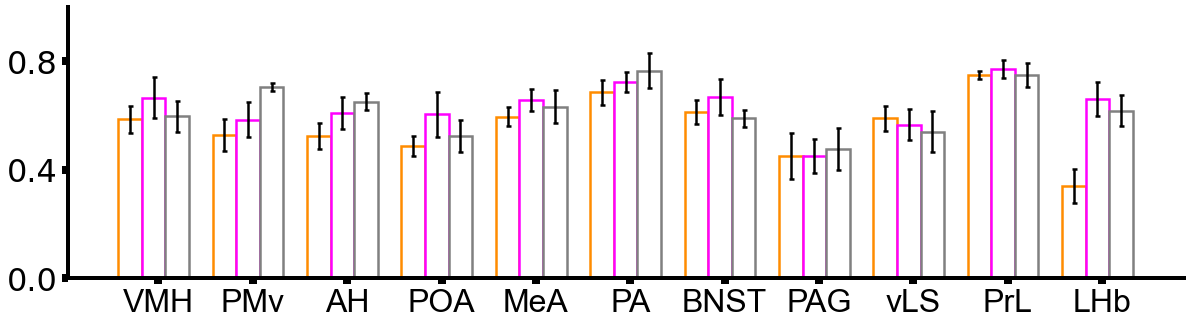

In [274]:
# agg_animal_scores_supercluster = np.nanmedian(supercluster_scores[:, -3:, 0:12], axis=1)
# obs_animal_scores_supercluster = np.nanmedian(supercluster_scores[:, -3:, 12:19], axis=1)
# non_animal_scores_supercluster = np.nanmedian(supercluster_scores[:, -3:, 19:], axis=1)

agg_animal_scores_supercluster = supercluster_scores[:, -3, 0:12]
obs_animal_scores_supercluster = supercluster_scores[:, -3, 12:19]
non_animal_scores_supercluster = supercluster_scores[:, -3, 19:]

ascending_idx = (np.array([12, 16, 8, 4, 10, 20, 6, 14, 2, 0, 18])/2).astype(int)

# Assuming agg_EIs, obs_EIs, non_EIs, and EI_regions are defined
weights_agg = np.nanmean(agg_animal_scores_supercluster, axis=1)
std_devs_agg = sem(agg_animal_scores_supercluster, axis=1, nan_policy='omit')  # SEM for agg_EIs
weights_obs = np.nanmean(obs_animal_scores_supercluster, axis=1)
std_devs_obs = sem(obs_animal_scores_supercluster, axis=1, nan_policy='omit')  # SEM for obs_EIs
weights_non = np.nanmean(non_animal_scores_supercluster, axis=1)
std_devs_non = sem(non_animal_scores_supercluster, axis=1, nan_policy='omit')  # SEM for non_EIs
# ascending_idx = np.argsort(weights_agg)

# Sort everything according to agg_EIs order
weights_agg_sorted = weights_agg[ascending_idx]
std_devs_agg_sorted = std_devs_agg[ascending_idx]
weights_obs_sorted = weights_obs[ascending_idx]
std_devs_obs_sorted = std_devs_obs[ascending_idx]
weights_non_sorted = weights_non[ascending_idx]
std_devs_non_sorted = std_devs_non[ascending_idx]

# Plotting
plt.figure(figsize=(20, 5))
bar_width = 0.25
indices = np.arange(len(weights_agg_sorted))

# Plot each class of weights
bar_settings = {
    'color': 'white',
    'linewidth': 2.5,
    'label': 'non_EIs',
    'capsize': 2.5,
    'error_kw': {'elinewidth': 2.5, 'capsize': 2.5, 'capthick': 2.5}
}

# Plot each class of weights using the settings
plt.bar(indices - bar_width, weights_agg_sorted, bar_width, yerr=std_devs_agg_sorted, edgecolor='darkorange', **bar_settings)
plt.bar(indices, weights_obs_sorted, bar_width, edgecolor='magenta', yerr=std_devs_obs_sorted, **bar_settings)
plt.bar(indices + bar_width, weights_non_sorted, bar_width, edgecolor='gray', yerr=std_devs_non_sorted, **bar_settings)
plt.xticks(indices+0.05, np.array(new_region_ids)[ascending_idx], rotation=360, fontfamily='Arial', fontsize=32)
plt.yticks([0, 0.4, 0.8], fontsize=32)
plt.ylim(top=1)
# plt.ylim(top=0.5)
sns.despine()
plt.savefig('.\\figures\\allI2E_hardFight_correlations_suprcluster.svg', dpi=600, bbox_inches='tight')

In [273]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Assuming your vectors are named vector1, vector2, and vector3
for r, roi in enumerate(new_region_ids):
    print(' ##### %s ##### ' % roi)
    agg_roi_activity = agg_animal_scores_supercluster[r, :][np.isnan(agg_animal_scores_supercluster[r, :])==False]
    obs_roi_activity = obs_animal_scores_supercluster[r, :][np.isnan(obs_animal_scores_supercluster[r, :])==False]
    non_roi_activity = non_animal_scores_supercluster[r, :][np.isnan(non_animal_scores_supercluster[r, :])==False]

     # Add the data to the DataFrame
    df = pd.DataFrame({
        'Activity': np.concatenate([agg_roi_activity, obs_roi_activity, non_roi_activity]),
        'Group': np.concatenate([['agg'] * len(agg_roi_activity), ['obs'] * len(obs_roi_activity), ['non'] * len(non_roi_activity)]),
    })

    # Perform the one-way ANOVA
    model = ols('Activity ~ C(Group)', data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("One-way ANOVA p-value:", anova_table['PR(>F)'][0])

    # Test for normality
    _, p_agg = stats.shapiro(agg_roi_activity)
    _, p_obs = stats.shapiro(obs_roi_activity)
    _, p_non = stats.shapiro(non_roi_activity)

    # If the p-value is greater than 0.05, the data is normally distributed
    if p_agg > 0.05 and p_obs > 0.05 and p_non > 0.05:
        # Perform t-tests
        _, p_agg_non = stats.ttest_ind(agg_roi_activity, non_roi_activity)
        _, p_agg_obs = stats.ttest_ind(agg_roi_activity, obs_roi_activity)
        _, p_obs_non = stats.ttest_ind(obs_roi_activity, non_roi_activity)
        print(f"agg vs non: t-test p-value = {p_agg_non}")
        print(f"agg vs obs: t-test p-value = {p_agg_obs}")
        print(f"obs vs non: t-test p-value = {p_obs_non}")
    else:
        # Perform Wilcoxon rank-sum tests
        _, p_agg_non = stats.mannwhitneyu(agg_roi_activity, non_roi_activity)
        _, p_agg_obs = stats.mannwhitneyu(agg_roi_activity, obs_roi_activity)
        _, p_obs_non = stats.mannwhitneyu(obs_roi_activity, non_roi_activity)
        print(f"agg vs non: Wilcoxon rank-sum test p-value = {p_agg_non}")
        print(f"agg vs obs: t-test p-value = {p_agg_obs}")
        print(f"obs vs non: Wilcoxon rank-sum test p-value = {p_obs_non}")

 ##### PrL ##### 
One-way ANOVA p-value: 0.8179951614527783
agg vs non: t-test p-value = 0.9790351077211322
agg vs obs: t-test p-value = 0.47970186010821536
obs vs non: t-test p-value = 0.6981379712166582
 ##### vLS ##### 
One-way ANOVA p-value: 0.8309180283111124
agg vs non: t-test p-value = 0.5657466693143653
agg vs obs: t-test p-value = 0.7567450855109402
obs vs non: t-test p-value = 0.7854693031354872
 ##### POA ##### 
One-way ANOVA p-value: 0.33592343951145487
agg vs non: t-test p-value = 0.5862864373523025
agg vs obs: t-test p-value = 0.1611291262975917
obs vs non: t-test p-value = 0.4592153524546323
 ##### BNST ##### 
One-way ANOVA p-value: 0.5776601240423608
agg vs non: Wilcoxon rank-sum test p-value = 0.6353646353646354
agg vs obs: t-test p-value = 0.36384204031262857
obs vs non: Wilcoxon rank-sum test p-value = 0.18065268065268064
 ##### AH ##### 
One-way ANOVA p-value: 0.1918799746759142
agg vs non: t-test p-value = 0.07795488554521933
agg vs obs: t-test p-value = 0.27494511

### Multi-area model

Here we employ a constrained model approach on a cluster by cluster basis

The idea being to predict VMHvl E activity with VMH I, PMv E and PMv I. Also separate one with PA and MeA

First we do this without any behavior

In [884]:
np.random.seed(42)
constrained_idxs = np.array([16, 14, 10, 13, 17, 11]) # PMV, PAG, MEA and VMH <-------------------------------------
scores_const = np.zeros((27, len(animals)))
weights_const = np.zeros((len(constrained_idxs), 27, len(animals)))
knockouts_const = weights_const.copy()
pbar = tqdm(enumerate(animals), total=len(animals)) # progress bar

for a, animal in pbar:
    pbar.set_description('Processing animal %i' % a)
    
    # load animal data
    if a <= 11:
        exp = 'aggression'
    elif a <= 18: 
        exp = 'observation'
    else:
        exp = 'nonsocial'

    trial_comps, rois = format4analysis(full_data, animal, exp=exp)
    rois = rois[:-2]
    norm_indices = [i for i, item in enumerate(region_ids) if item in set(rois)]
    trial_comps = np.concatenate(trial_comps, axis=2)
    
    # create arrays for storage of weights and % drop across epochs
    epoch_scores = np.zeros((trial_comps.shape[2]))
    epoch_scores[:] = np.nan
    epoch_weights = np.zeros((len(constrained_idxs), trial_comps.shape[2]))
    epoch_weights[:] = np.nan
    epoch_knockouts = epoch_weights.copy()
    
    # containers for cross-validated score, weights and knockouts
    
    for e in np.arange(trial_comps.shape[-1]):
        epoch = trial_comps[:, :, e]
        for region_idx, orig_idx in enumerate(norm_indices):
            if orig_idx != 12: # only VMH
                continue
            
            # format y
            y = epoch[:, region_idx]
            y = y[~np.isnan(y)].reshape(-1,1)

            # format X
            X = epoch[:, constrained_idxs]
            X = X[:, ~np.all(np.isnan(X), axis=0)]
            X = X[~np.any(np.isnan(X), axis=1)]
            orig_X_shape = X.shape
            new_X_shape = X.shape
            if new_X_shape[1] < len(constrained_idxs): # if PMv is missing
                continue

            try:
                # fit model
                model = sm.GLM(y, X).fit()
                best_score = r2_score(y, model.predict(X))
                if best_score<0:
                    best_score=0
                epoch_scores[e] = best_score
                epoch_weights[:, e] = model.params.flatten()
                # perform region knockouts
                knockouts = np.zeros((X.shape[1]))
                for knockout_idx in np.arange(X.shape[1]):
                    avg_ko = []
                    for n in np.arange(3):
                        X_shuffled = X.copy()
                        np.random.shuffle(X_shuffled[:, knockout_idx])
                        y_pred = model.predict(X_shuffled)
                        ko_score = r2_score(y, y_pred)
                        if ko_score < 0:
                            ko_score = 0
                        avg_ko.append(ko_score)
                    ko_score = np.mean(avg_ko) 
                    knockout_score_difference = best_score - ko_score
                    # knockout_score_difference = ((best_score - ko_score) / best_score) * 100
                    if knockout_score_difference < 0:
                        knockout_score_difference = 0
                    knockouts[knockout_idx] = knockout_score_difference
                epoch_knockouts[:, e] = knockouts

            except ValueError: # in case y is nan
                # print('Skipping %s' % region_ids[population])
                continue

    scores_const[:, a] = epoch_scores
    weights_const[:, :, a] = epoch_weights
    knockouts_const[:, :, a] = epoch_knockouts

            

    

Processing animal 24: 100%|██████████| 25/25 [00:23<00:00,  1.08it/s]


In [885]:
# Gather tables
all_tables = {}
animals2exclude = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
sessions2exclude = [0, 24] # for NON
weights2map = np.transpose(knockouts_const, [1,0,2])
# weights2map = np.abs(weights2map)


all_tables = []
for r, roi in enumerate(constrained_idxs):
    table = pd.DataFrame(columns=['cross_day', 'cross_session', 'within_day', 'subject', 'dependent_variable'])
    for animal in np.arange((len(np.concatenate([agg_animals, obs_animals, non_animals]))))[animals2exclude]:
        sample = weights2map[sessions2exclude[0]:sessions2exclude[1], r, animal]
        cross_day_info = np.repeat(np.arange(9), 3)[sessions2exclude[0]:sessions2exclude[1]].astype(float)
        within_day_info = np.tile(np.arange(3), 9)[sessions2exclude[0]:sessions2exclude[1]].astype(float)
        session_info = np.arange(27)[sessions2exclude[0]:sessions2exclude[1]].astype(float)
        subject_info = np.repeat(animal, 27)[sessions2exclude[0]:sessions2exclude[1]]
        if animal<=11:
            group_info = np.repeat(0, 27)[sessions2exclude[0]:sessions2exclude[1]]
        elif animal<=18:
            group_info = np.repeat(1, 27)[sessions2exclude[0]:sessions2exclude[1]]
        else:
            group_info = np.repeat(2, 27)[sessions2exclude[0]:sessions2exclude[1]]
        table = pd.concat([table, pd.DataFrame({'cross_day': cross_day_info, 'cross_session': session_info, 'within_day': within_day_info, 'subject': subject_info, 'exp_group': group_info, 'dependent_variable': sample})])
    all_tables.append(table)

In [886]:
# Run LM
new_idx = np.arange(len(constrained_idxs))
norm_idx = new_idx.copy()
all_labels = ['PMv', 'PAG', 'MeA', 'VMH', 'PMv', 'MeA']
# all_labels = ['PMv', 'PAG', 'MeA', 'VMH', 'PMv', 'MeA', 'POA']

mean_func = np.nanmean
agg_decouples = [mean_func(weights2map[i:i+3, :, :12], axis=0).reshape(len(constrained_idxs), 12, 1) for i in np.arange(0, 27, 3)]
agg_decouples = np.concatenate(agg_decouples[:-1], axis=2)
obs_decouples = [mean_func(weights2map[i:i+3, :, 12:19], axis=0).reshape(len(constrained_idxs), 7, 1) for i in np.arange(0, 27, 3)]
obs_decouples = np.concatenate(obs_decouples[:-1], axis=2)
data4stats = [agg_decouples.copy(), obs_decouples.copy()]

p_values = []
time_values = []
bses = []
for r,roi in enumerate(norm_idx):
    print('############ %s ############' % all_labels[r])
    for i, d in enumerate(data4stats):
        # remove nans
        data2stat = d[roi]
        n_nans = len(np.unique(np.where(np.isnan(data2stat))[0]))
        data2stat = data2stat[~np.isnan(data2stat)].reshape(data2stat.shape[0]-n_nans, data2stat.shape[1])
        if data2stat.shape[0] == 0:
            p_values.append(1.)
            continue
        
        # package into DF
        df = pd.DataFrame(data2stat.flatten(), columns=['Measurement'])
        df['Subject'] = np.repeat(np.arange(data2stat.shape[0]), agg_decouples.shape[-1])
        df['Time'] = np.tile(np.arange(agg_decouples.shape[-1]), data2stat.shape[0])

        # Perform the repeated measures ANOVA
        # anova = AnovaRM(df, 'Measurement', 'Subject', within=['Time'])
        # res = anova.fit()

        # Alternatively perform mixed LM
        model = MixedLM(df['Measurement'], df[['Time']], groups=df['Subject'])
        res = model.fit()

        if i==0:
            descrip = 'AGG'
        else:
            descrip = 'OBS'
        # print('%s p-value = %f' % (descrip, res.anova_table['Pr > F']['Time']))
        print('%s p-value = %f' % (descrip, res.pvalues['Time']))
        p_values.append(res.pvalues['Time'])
        time_values.append(res.fe_params['Time'])
        bses.append(res.bse['Time'])
        
ascending_idx = new_idx.copy()
p_values_AGG = np.array(p_values)[::2]
fs_AGG = np.array(time_values)[::2]
bses_AGG = np.array(bses)[::2]
p_values_OBS = np.array(p_values)[1::2]
fs_OBS = np.array(time_values)[1::2]
bses_OBS = np.array(bses)[1::2]

C:\Users\Jorge\AppData\Local\Temp\ipykernel_4796\187980261.py:8: RuntimeWarning: Mean of empty slice
  agg_decouples = [mean_func(weights2map[i:i+3, :, :12], axis=0).reshape(len(constrained_idxs), 12, 1) for i in np.arange(0, 27, 3)]
c:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the 

############ PMv ############
AGG p-value = 0.587869
OBS p-value = 0.904138
############ PAG ############
AGG p-value = 0.000208
OBS p-value = 0.358813
############ MeA ############
AGG p-value = 0.385756
OBS p-value = 0.099910
############ VMH ############
AGG p-value = 0.000004
OBS p-value = 0.114812
############ PMv ############
AGG p-value = 0.000189
OBS p-value = 0.001639
############ MeA ############
AGG p-value = 0.068593
OBS p-value = 0.276618


c:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


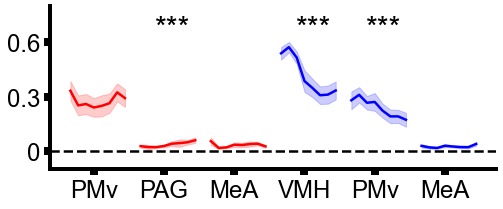

In [887]:
# Plot correlation changes AGG

from scipy.stats import sem

bar_settings = {
    'color': 'white',
    'linewidth': 2.75,
    'capsize': 2.75,
    'error_kw': {'elinewidth': 2.5, 'capsize': 5, 'capthick': 2.5, 'markeredgewidth': 2}}


# Create a figure for the line plots
fig1, ax1 = plt.subplots(figsize=(8, 3))

# Counter for the bar plot positions
bar_counter = 0
factor = 9

ascending_idx = new_idx.copy()

indices = []

for t, roi in enumerate(all_labels):
    table = all_tables[t]
    table = table.dropna(axis=0)
    table = table.reset_index(drop=True)

    # Get unique groups
    groups = table['exp_group'].unique()

    # Color assignment
    if t < 3:
        color='red'
    else:
        color='blue'

    # Plot
    group = 0
    subset = table[table['exp_group'] == group]
    means = subset.groupby('cross_day')['dependent_variable'].mean()
    errors = subset.groupby('cross_day')['dependent_variable'].apply(sem)
    ax1.plot(means.index.values + t*factor, means.values, color=color, linewidth=2.5)
    ax1.fill_between(means.index.values + t*factor, means.values - errors.values, means.values + errors.values, alpha=0.2, color=color)
    indices.append(t*factor)

# Cleaning
ax1.set_xticks((np.arange(0, (len(constrained_idxs))*factor, factor)+2)+1, all_labels, fontsize=24, fontfamily='Arial')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylim(top=0.8, bottom=-0.1)
ax1.set_yticks([0, 0.3, 0.6])
ax1.set_yticklabels([0, 0.3, 0.6], fontsize=24, fontfamily='Arial');
ax1.set_title('')
ax1.axhline(0, color='black', linewidth=2.5, linestyle='--')

# Adding stars
try:
    for p_value, index in zip(p_values_AGG, indices):
        # If the p-value is less than 0.05, add a "*" above the line
        if p_value < 0.06:
            if p_value < 0.001:
                marker='***'
            elif p_value < 0.01:
                marker = '**'
            elif p_value < 0.05:
                marker = '*'
            elif p_value < 0.06:
                marker = ''
            plt.text(index+4, 0.6, marker, ha='center', va='bottom', fontsize=30, color='black', fontfamily='Arial')
except ValueError:
    pass

# Save fig1 as an SVG file
# fig1.savefig('.\\figures\\VMH_knockouts_AGG.svg', dpi=300, format='svg')

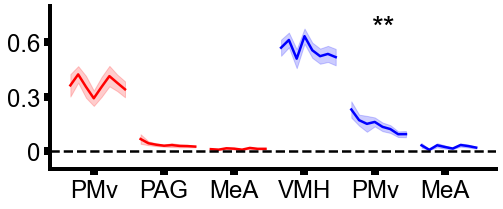

In [888]:
# Plot correlation changes OBS

# Create a figure for the line plots
fig1, ax1 = plt.subplots(figsize=(8, 3))

# Counter for the bar plot positions
bar_counter = 0
factor = 9

ascending_idx = new_idx.copy()

indices = []

for t, roi in enumerate(all_labels):
    table = all_tables[t]
    table = table.dropna(axis=0)
    table = table.reset_index(drop=True)

    # Get unique groups
    groups = table['exp_group'].unique()

    # Color assignment
    if t < 3:
        color='red'
    else:
        color='blue'

    # Plot
    group = 1
    subset = table[table['exp_group'] == group]
    means = subset.groupby('cross_day')['dependent_variable'].mean()
    errors = subset.groupby('cross_day')['dependent_variable'].apply(sem)
    ax1.plot(means.index.values + t*factor, means.values, color=color, linewidth=2.5)
    ax1.fill_between(means.index.values + t*factor, means.values - errors.values, means.values + errors.values, alpha=0.2, color=color)
    indices.append(t*factor)

# Cleaning
ax1.set_xticks((np.arange(0, (len(constrained_idxs))*factor, factor)+2)+1, all_labels, fontsize=24, fontfamily='Arial')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
# ax1.set_ylim(top=1, bottom=-1)
ax1.set_ylim(top=0.8, bottom=-0.1)
# edges = 0.75
# ax1.set_yticks([-edges, 0, edges]);
ax1.set_yticks([0, 0.3, 0.6])
# ax1.set_yticklabels([-edges, 0, edges], fontsize=32, fontfamily='Arial');
ax1.set_yticklabels([0, 0.3, 0.6], fontsize=24, fontfamily='Arial');
ax1.set_title('')
ax1.axhline(0, color='black', linewidth=2.5, linestyle='--')

# Adding stars
try:
    for p_value, index in zip(p_values_OBS, indices):
        # If the p-value is less than 0.05, add a "*" above the line
        if p_value < 0.06:
            if p_value < 0.001:
                marker='***'
            elif p_value < 0.01:
                marker = '**'
            elif p_value < 0.05:
                marker = '*'
            elif p_value < 0.06:
                marker = ''
            plt.text(index+4, 0.6, marker, ha='center', va='bottom', fontsize=30, color='black', fontfamily='Arial')
except ValueError:
    pass

# Save fig1 as an SVG file
# fig1.savefig('.\\figures\\VMH_knockouts_OBS.svg', dpi=300, format='svg')

C:\Users\Jorge\AppData\Local\Temp\ipykernel_4796\817854019.py:1: RuntimeWarning: Mean of empty slice
  agg_weights_const = np.nanmean(knockouts_const[:, -3:, 0:12], axis=1)


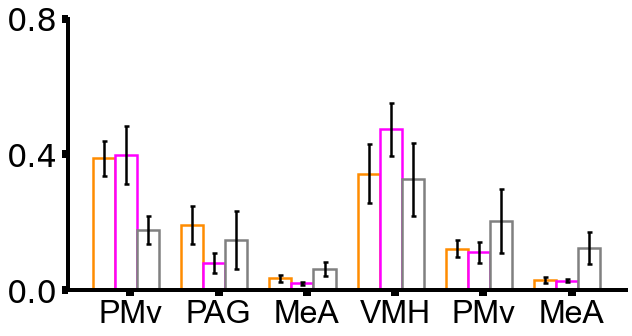

In [889]:
agg_weights_const = np.nanmean(knockouts_const[:, -3:, 0:12], axis=1)
obs_weights_const = np.nanmean(knockouts_const[:, -3:, 12:19], axis=1)
non_weights_const = np.nanmean(knockouts_const[:, -3:, 19:], axis=1)

# Assuming agg_EIs, obs_EIs, non_EIs, and EI_regions are defined
weights_agg = np.nanmean(agg_weights_const, axis=1)
std_devs_agg = sem(agg_weights_const, axis=1, nan_policy='omit').data  # SEM for agg_EIs
weights_obs = np.nanmean(obs_weights_const, axis=1)
std_devs_obs = sem(obs_weights_const, axis=1, nan_policy='omit')  # SEM for obs_EIs
weights_non = np.nanmean(non_weights_const, axis=1)
std_devs_non = sem(non_weights_const, axis=1, nan_policy='omit')  # SEM for non_EIs

# Sort everything according to agg_EIs order
weights_agg_sorted = weights_agg[ascending_idx]
std_devs_agg_sorted = std_devs_agg[ascending_idx]
weights_obs_sorted = weights_obs[ascending_idx]
std_devs_obs_sorted = std_devs_obs[ascending_idx]
weights_non_sorted = weights_non[ascending_idx]
std_devs_non_sorted = std_devs_non[ascending_idx]

# Plotting
plt.figure(figsize=(10, 5))
bar_width = 0.25
indices = np.arange(len(weights_agg_sorted))

# Plot each class of weights
bar_settings = {
    'color': 'white',
    'linewidth': 2.5,
    'label': 'non_EIs',
    'capsize': 2.5,
    'error_kw': {'elinewidth': 2.5, 'capsize': 2.5, 'capthick': 2.5}
}

# Plot each class of weights using the settings
plt.bar(indices - bar_width, weights_agg_sorted, bar_width, yerr=std_devs_agg_sorted, edgecolor='darkorange', **bar_settings)
plt.bar(indices, weights_obs_sorted, bar_width, edgecolor='magenta', yerr=std_devs_obs_sorted, **bar_settings)
plt.bar(indices + bar_width, weights_non_sorted, bar_width, edgecolor='gray', yerr=std_devs_non_sorted, **bar_settings)
plt.xticks(indices+0.05, all_labels, rotation=360, fontfamily='Arial', fontsize=32)
plt.yticks([0, 0.4, 0.8], fontsize=32)
# plt.ylim(top=0.41)
sns.despine()
# plt.savefig('.\\figures\\VMH_KOs_HF.svg', dpi=600, bbox_inches='tight')

In [890]:
# Assuming your vectors are named vector1, vector2, and vector3
for r, roi in enumerate(all_labels):
    try: 
        print(' ##### %s ##### ' % roi)
        agg_roi_activity = agg_weights_const[r, :][np.isnan(agg_weights_const[r, :])==False]
        obs_roi_activity = obs_weights_const[r, :][np.isnan(obs_weights_const[r, :])==False]
        non_roi_activity = non_weights_const[r, :][np.isnan(non_weights_const[r, :])==False]

        # Add the data to the DataFrame
        df = pd.DataFrame({
            'Activity': np.concatenate([agg_roi_activity, obs_roi_activity, non_roi_activity]),
            'Group': np.concatenate([['agg'] * len(agg_roi_activity), ['obs'] * len(obs_roi_activity), ['non'] * len(non_roi_activity)]),
        })

        # Perform the one-way ANOVA
        model = ols('Activity ~ C(Group)', data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        print("One-way ANOVA p-value:", anova_table['PR(>F)'][0])

        # Test for normality
        _, p_agg = stats.shapiro(agg_roi_activity)
        _, p_obs = stats.shapiro(obs_roi_activity)
        _, p_non = stats.shapiro(non_roi_activity)

        # If the p-value is greater than 0.05, the data is normally distributed
        if p_agg > 0.05 and p_obs > 0.05 and p_non > 0.05:
            # Perform t-tests
            _, p_agg_non = stats.ttest_ind(agg_roi_activity, non_roi_activity)
            _, p_agg_obs = stats.ttest_ind(agg_roi_activity, obs_roi_activity)
            _, p_obs_non = stats.ttest_ind(obs_roi_activity, non_roi_activity)
            print(f"agg vs non: t-test p-value = {p_agg_non}")
            print(f"agg vs obs: t-test p-value = {p_agg_obs}")
            print(f"obs vs non: t-test p-value = {p_obs_non}")
        else:
            # Perform Wilcoxon rank-sum tests
            _, p_agg_non = stats.mannwhitneyu(agg_roi_activity, non_roi_activity)
            _, p_agg_obs = stats.mannwhitneyu(agg_roi_activity, obs_roi_activity)
            _, p_obs_non = stats.mannwhitneyu(obs_roi_activity, non_roi_activity)
            print(f"agg vs non: Wilcoxon rank-sum test p-value = {p_agg_non}")
            print(f"agg vs obs: t-test p-value = {p_agg_obs}")
            print(f"obs vs non: Wilcoxon rank-sum test p-value = {p_obs_non}")
    except ValueError:
        continue

 ##### PMv ##### 
One-way ANOVA p-value: 0.05185779279042659
agg vs non: t-test p-value = 0.010671729804541475
agg vs obs: t-test p-value = 0.915867029609096
obs vs non: t-test p-value = 0.04926915957365647
 ##### PAG ##### 
One-way ANOVA p-value: 0.3948277701392313
agg vs non: Wilcoxon rank-sum test p-value = 0.5337995337995338
agg vs obs: t-test p-value = 0.09731934731934733
obs vs non: Wilcoxon rank-sum test p-value = 0.7307692307692307
 ##### MeA ##### 
One-way ANOVA p-value: 0.0828066320112631
agg vs non: t-test p-value = 0.2210299737618598
agg vs obs: t-test p-value = 0.21304118404549346
obs vs non: t-test p-value = 0.05039292877224862
 ##### VMH ##### 
One-way ANOVA p-value: 0.4618239639402135
agg vs non: Wilcoxon rank-sum test p-value = 0.5337995337995338
agg vs obs: t-test p-value = 0.16491841491841494
obs vs non: Wilcoxon rank-sum test p-value = 0.18065268065268064
 ##### PMv ##### 
One-way ANOVA p-value: 0.45016666851014364
agg vs non: t-test p-value = 0.38647366278013096
ag

Second: we isolate social clusters

In [578]:
np.random.seed(42)
constrained_idxs = np.array([16, 14, 10, 13, 17, 11]) # PMV, PAG, MEA and VMH <-------------------------------------
constrained_idxs = np.array([16, 14, 10, 20, 13, 17, 11, 21])
constrained_idxs = np.array([16, 8, 4, 10, 20, 14, 13, 17, 9, 5, 11, 21])
scores_const = np.zeros((27, 13, len(animals)))
weights_const = np.zeros((len(constrained_idxs), 27, 13, len(animals)))
knockouts_const = weights_const.copy()
pbar = tqdm(enumerate(animals), total=len(animals)) # progress bar

for a, animal in pbar:
    pbar.set_description('Processing animal %i' % a)
    
    # load animal data
    if a <= 11:
        exp = 'aggression'
    elif a <= 18: 
        exp = 'observation'
    else:
        exp = 'nonsocial'

    trial_comps, rois = format4analysis(full_data, animal, exp=exp)
    rois = rois[:-2]
    norm_indices = [i for i, item in enumerate(region_ids) if item in set(rois)]
    trial_comps = np.concatenate(trial_comps, axis=2)
    cluster_comps = grab_cluster_idxs(full_data, animal, exp=exp)
    
    # create arrays for storage of weights and % drop across epochs
    epoch_scores = np.zeros((trial_comps.shape[2], 13))
    epoch_scores[:] = np.nan
    epoch_weights = np.zeros((len(constrained_idxs), trial_comps.shape[2], 13))
    epoch_weights[:] = np.nan
    epoch_knockouts = epoch_weights.copy()
    
    # containers for cross-validated score, weights and knockouts
    
    for e in np.arange(trial_comps.shape[-1]):
        epoch = trial_comps[:, :, e]
        for region_idx, orig_idx in enumerate(norm_indices):
            if orig_idx != 12: # only VMH
                continue
            
            # format y
            y = epoch[:, region_idx]
            y = y[~np.isnan(y)].reshape(-1,1)
            if np.isnan(y).all():
                continue

            # format X
            X = epoch[:, constrained_idxs]
            orig_X_shape = X.shape
            X = X[:, ~np.all(np.isnan(X), axis=0)]
            X = X[~np.any(np.isnan(X), axis=1)]
            new_X_shape = X.shape
            if new_X_shape[1] < len(constrained_idxs): # if PMv is missing
                continue
            
            # index into clusters
            for c in np.arange(cluster_comps[e].shape[1]):
                cluster_indices = np.where(cluster_comps[e][:, c]==1)[0]
                if len(cluster_indices) > 80:
                    X_hat = X[cluster_indices, :]
                    y_hat = y[cluster_indices, :]
                    # fit model
                    try:
                        model = sm.GLM(y_hat, X_hat).fit()
                        best_score = r2_score(y_hat, model.predict(X_hat))
                        if best_score<0:
                            best_score=0
                        epoch_scores[e, c] = best_score
                        epoch_weights[:, e, c] = model.params.flatten()
                        # perform region knockouts
                        knockouts = np.zeros((X.shape[1]))
                        for knockout_idx in np.arange(X.shape[1]):
                            avg_ko = []
                            for n in np.arange(3):
                                X_shuffled = X_hat.copy()
                                np.random.shuffle(X_shuffled[:, knockout_idx])
                                y_pred = model.predict(X_shuffled)
                                ko_score = r2_score(y_hat, y_pred)
                                if ko_score < 0:
                                    ko_score = 0
                                avg_ko.append(ko_score)
                            ko_score = np.mean(avg_ko) 
                            knockout_score_difference = best_score - ko_score
                            # knockout_score_difference = ((best_score - ko_score) / best_score) * 100
                            if knockout_score_difference < 0:
                                knockout_score_difference = 0
                            knockouts[knockout_idx] = knockout_score_difference
                        epoch_knockouts[:, e, c] = knockouts
                    except ValueError:
                        continue

    scores_const[:, :, a] = epoch_scores
    weights_const[:, :, :, a] = epoch_weights
    knockouts_const[:, :, :,  a] = epoch_knockouts

            

    

Processing animal 24: 100%|██████████| 25/25 [01:42<00:00,  4.12s/it]


In [821]:
# Gather tables
all_tables = {}
animals2exclude = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
sessions2exclude = [0, 24] # for NON
# behaviors = np.arange(8)
# behaviors = [0,1,2,3,4,6,7]
# behaviors = [0,1,2,3,10,7,5]
# behaviors = [0,1,2,3,4,7,8]
behaviors = np.arange(10)
# behaviors = np.arange(10, 13)
supercluster_kos = np.nanmean(knockouts_const[:, :, behaviors, :], axis=2)
weights2map = np.transpose(supercluster_kos, [1,0,2])
all_labels = ['PMv', 'AH', 'POA', 'MeA', 'PA', 'PAG', 'VMH', 'PMv', 'AH', 'POA', 'MeA', 'PA']


all_tables = []
for r, roi in enumerate(constrained_idxs):
    table = pd.DataFrame(columns=['cross_day', 'cross_session', 'within_day', 'subject', 'dependent_variable'])
    for animal in np.arange((len(np.concatenate([agg_animals, obs_animals, non_animals]))))[animals2exclude]:
        sample = weights2map[sessions2exclude[0]:sessions2exclude[1], r, animal]
        cross_day_info = np.repeat(np.arange(9), 3)[sessions2exclude[0]:sessions2exclude[1]].astype(float)
        within_day_info = np.tile(np.arange(3), 9)[sessions2exclude[0]:sessions2exclude[1]].astype(float)
        session_info = np.arange(27)[sessions2exclude[0]:sessions2exclude[1]].astype(float)
        subject_info = np.repeat(animal, 27)[sessions2exclude[0]:sessions2exclude[1]]
        if animal<=11:
            group_info = np.repeat(0, 27)[sessions2exclude[0]:sessions2exclude[1]]
        elif animal<=18:
            group_info = np.repeat(1, 27)[sessions2exclude[0]:sessions2exclude[1]]
        else:
            group_info = np.repeat(2, 27)[sessions2exclude[0]:sessions2exclude[1]]
        table = pd.concat([table, pd.DataFrame({'cross_day': cross_day_info, 'cross_session': session_info, 'within_day': within_day_info, 'subject': subject_info, 'exp_group': group_info, 'dependent_variable': sample})])
    all_tables.append(table)

C:\Users\Jorge\AppData\Local\Temp\ipykernel_53668\3663819430.py:11: RuntimeWarning: Mean of empty slice
  supercluster_kos = np.nanmean(knockouts_const[:, :, behaviors, :], axis=2)


In [822]:
# Run LM
new_idx = np.arange(len(constrained_idxs))
norm_idx = new_idx.copy()

mean_func = np.nanmean
agg_decouples = [mean_func(weights2map[i:i+3, :, :12], axis=0).reshape(len(constrained_idxs), 12, 1) for i in np.arange(0, 27, 3)]
agg_decouples = np.concatenate(agg_decouples[:-1], axis=2)
obs_decouples = [mean_func(weights2map[i:i+3, :, 12:19], axis=0).reshape(len(constrained_idxs), 7, 1) for i in np.arange(0, 27, 3)]
obs_decouples = np.concatenate(obs_decouples[:-1], axis=2)
data4stats = [agg_decouples.copy(), obs_decouples.copy()]

p_values = []
for r,roi in enumerate(norm_idx):
    print('############ %s ############' % all_labels[r])
    for i, d in enumerate(data4stats):
        # remove nans
        data2stat = d[roi]
        n_nans = len(np.unique(np.where(np.isnan(data2stat))[0]))
        data2stat = data2stat[~np.isnan(data2stat)].reshape(data2stat.shape[0]-n_nans, data2stat.shape[1])
        if data2stat.shape[0] == 0:
            p_values.append(1.)
            continue
        
        # package into DF
        df = pd.DataFrame(data2stat.flatten(), columns=['Measurement'])
        df['Subject'] = np.repeat(np.arange(data2stat.shape[0]), agg_decouples.shape[-1])
        df['Time'] = np.tile(np.arange(agg_decouples.shape[-1]), data2stat.shape[0])

        # Alternatively perform mixed LM
        model = MixedLM(df['Measurement'], df[['Time']], groups=df['Subject'])
        res = model.fit()
        p_values.append(res.pvalues['Time'])

p_values_AGG = np.array(p_values)[::2]
p_values_OBS = np.array(p_values)[1::2]
p_values_AGG_corrected = multipletests(p_values_AGG, method='bonferroni')[1]
p_values_OBS_corrected = multipletests(p_values_OBS, method='bonferroni')[1]

C:\Users\Jorge\AppData\Local\Temp\ipykernel_53668\1712165236.py:6: RuntimeWarning: Mean of empty slice
  agg_decouples = [mean_func(weights2map[i:i+3, :, :12], axis=0).reshape(len(constrained_idxs), 12, 1) for i in np.arange(0, 27, 3)]


############ PMv ############
############ AH ############
############ POA ############


c:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

############ MeA ############
############ PA ############
############ PAG ############
############ VMH ############
############ PMv ############
############ AH ############
############ POA ############
############ MeA ############
############ PA ############


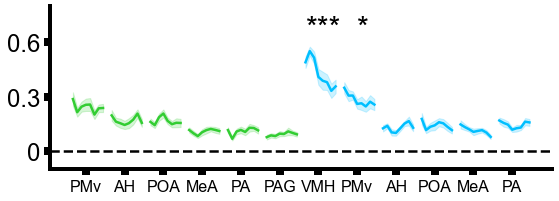

In [823]:
# Plot correlation changes AGG

from scipy.stats import sem

bar_settings = {
    'color': 'white',
    'linewidth': 2.75,
    'capsize': 2.75,
    'error_kw': {'elinewidth': 2.5, 'capsize': 5, 'capthick': 2.5, 'markeredgewidth': 2}}


# Create a figure for the line plots
fig1, ax1 = plt.subplots(figsize=(9,3))

# Counter for the bar plot positions
bar_counter = 0
factor = 9

ascending_idx = new_idx.copy()

indices = []

for t, roi in enumerate(all_labels):
    table = all_tables[t]
    table = table.dropna(axis=0)
    table = table.reset_index(drop=True)

    # Get unique groups
    groups = table['exp_group'].unique()

    # Color assignment
    if t < 6:
        color='limegreen'
    else:
        color='deepskyblue'

    # Plot
    group = 0
    subset = table[table['exp_group'] == group]
    means = subset.groupby('cross_day')['dependent_variable'].mean()
    errors = subset.groupby('cross_day')['dependent_variable'].apply(sem)
    ax1.plot(means.index.values + t*factor, means.values, color=color, linewidth=2.5)
    ax1.fill_between(means.index.values + t*factor, means.values - errors.values, means.values + errors.values, alpha=0.2, color=color)
    indices.append(t*factor)

# Cleaning
ax1.set_xticks((np.arange(0, (len(constrained_idxs))*factor, factor)+2)+1, all_labels, fontsize=16, fontfamily='Arial')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylim(top=0.8, bottom=-0.1)
ax1.set_yticks([0, 0.3, 0.6])
ax1.set_yticklabels([0, 0.3, 0.6], fontsize=24, fontfamily='Arial');
ax1.set_title('')
ax1.axhline(0, color='black', linewidth=2.5, linestyle='--')

# Adding stars
try:
    for p_value, index in zip(p_values_AGG_corrected, indices):
        # If the p-value is less than 0.05, add a "*" above the line
        if p_value < 0.06:
            if p_value < 0.001:
                marker='***'
            elif p_value < 0.01:
                marker = '**'
            elif p_value < 0.05:
                marker = '*'
            elif p_value < 0.06:
                marker = ''
            plt.text(index+4, 0.6, marker, ha='center', va='bottom', fontsize=30, color='black', fontfamily='Arial')
except ValueError:
    pass

# Save fig1 as an SVG file
# fig1.savefig('.\\figures\\VMH_knockouts_overtime_AGG.svg', dpi=300, format='svg')

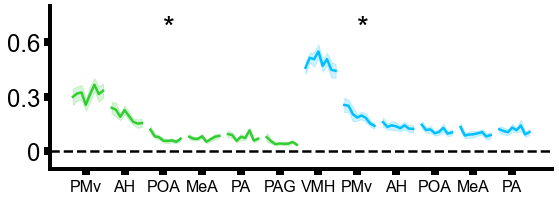

In [824]:
# Plot correlation changes OBS

# Create a figure for the line plots
fig1, ax1 = plt.subplots(figsize=(9, 3))

# Counter for the bar plot positions
bar_counter = 0
factor = 9

ascending_idx = new_idx.copy()

indices = []

for t, roi in enumerate(all_labels):
    table = all_tables[t]
    table = table.dropna(axis=0)
    table = table.reset_index(drop=True)

    # Get unique groups
    groups = table['exp_group'].unique()

    # Color assignment
    if t < 6:
        color='limegreen'
    else:
        color='deepskyblue'

    # Plot
    group = 1
    subset = table[table['exp_group'] == group]
    means = subset.groupby('cross_day')['dependent_variable'].mean()
    errors = subset.groupby('cross_day')['dependent_variable'].apply(sem)
    ax1.plot(means.index.values + t*factor, means.values, color=color, linewidth=2.5)
    ax1.fill_between(means.index.values + t*factor, means.values - errors.values, means.values + errors.values, alpha=0.2, color=color)
    indices.append(t*factor)

# Cleaning
ax1.set_xticks((np.arange(0, (len(constrained_idxs))*factor, factor)+2)+1, all_labels, fontsize=16, fontfamily='Arial')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylim(top=0.8, bottom=-0.1)
ax1.set_yticks([0, 0.3, 0.6])
ax1.set_yticklabels([0, 0.3, 0.6], fontsize=24, fontfamily='Arial');
ax1.set_title('')
ax1.axhline(0, color='black', linewidth=2.5, linestyle='--')

# Adding stars
try:
    for p_value, index in zip(p_values_OBS_corrected, indices):
        # If the p-value is less than 0.05, add a "*" above the line
        if p_value < 0.06:
            if p_value < 0.001:
                marker='***'
            elif p_value < 0.01:
                marker = '**'
            elif p_value < 0.05:
                marker = '*'
            elif p_value < 0.06:
                marker = ''
            plt.text(index+4, 0.6, marker, ha='center', va='bottom', fontsize=30, color='black', fontfamily='Arial')
except ValueError:
    pass

# Save fig1 as an SVG file
# fig1.savefig('.\\figures\\VMH_knockouts_overtime_OBS.svg', dpi=300, format='svg')

PMv
AGG vs NON PMv : 0.430359
OBS vs NON PMv : 0.430359
AH
AGG vs NON AH : 0.028535
OBS vs NON AH : 0.014056
POA
AGG vs NON POA : 0.021805
OBS vs NON POA : 0.035701
MeA
AGG vs NON MeA : 0.895632
OBS vs NON MeA : 0.090755
PA
AGG vs NON PA : 0.704936
OBS vs NON PA : 0.704936
PAG
AGG vs NON PAG : 0.008939
OBS vs NON PAG : 0.664484
VMH
AGG vs NON VMH : 0.025544
OBS vs NON VMH : 0.353048
PMv
AGG vs NON PMv : 0.000628
OBS vs NON PMv : 0.000076
AH
AGG vs NON AH : 0.017536
OBS vs NON AH : 0.003203
POA
AGG vs NON POA : 0.421587
OBS vs NON POA : 0.230028
MeA
AGG vs NON MeA : 0.001213
OBS vs NON MeA : 0.007405
PA
AGG vs NON PA : 0.086288
OBS vs NON PA : 0.408993


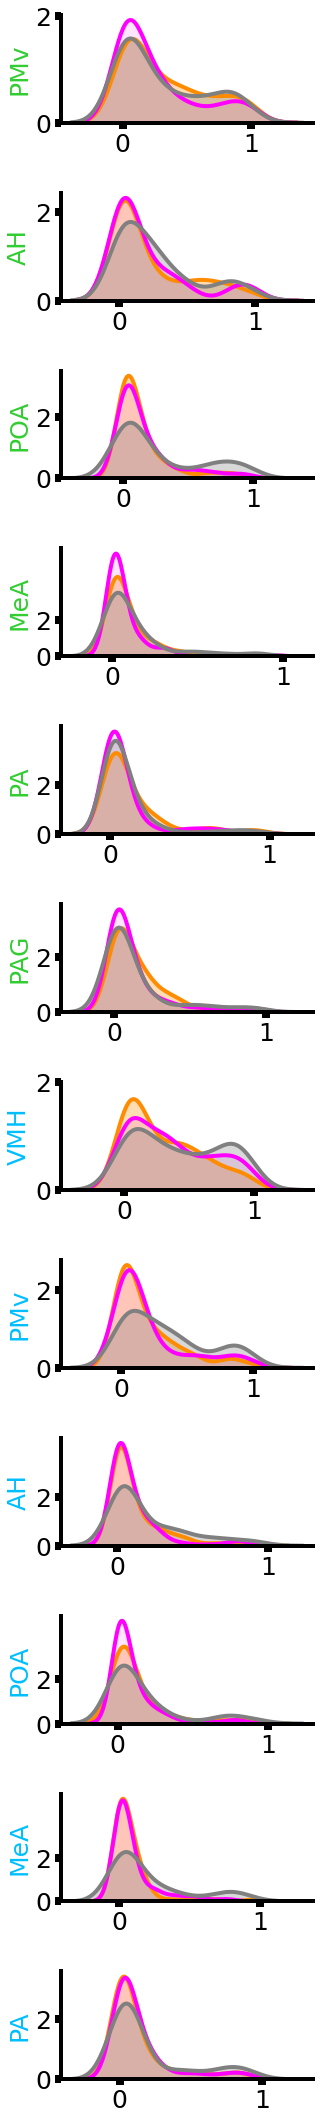

In [820]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ks_2samp
lw=4
behaviors = [0,1,2,3,4,6,7,9] 
# behaviors = [10,11,12]

agg = knockouts_const[:, -3:, behaviors, 0:12].reshape(len(all_labels), len(behaviors)*3, 12)
obs = knockouts_const[:, -3:, behaviors, 12:19].reshape(len(all_labels), len(behaviors)*3, 7)
non = knockouts_const[:, -3:, behaviors, 19:].reshape(len(all_labels), len(behaviors)*3, 6)
fig, ax = plt.subplots(len(all_labels), 1, figsize=(5, 30))
for r, roi in enumerate(all_labels):
    try: 
        agg_roi_activity = agg[r].flatten()[np.isnan(agg[r].flatten()) == False]
        obs_roi_activity = obs[r].flatten()[np.isnan(obs[r].flatten()) == False]
        non_roi_activity = non[r].flatten()[np.isnan(non[r].flatten()) == False]

        # plot everything
        sns.kdeplot(agg_roi_activity, ax=ax[r], color='darkorange', multiple='layer', fill=True, alpha=0.3, lw=0)
        sns.kdeplot(agg_roi_activity, ax=ax[r], color='darkorange', lw=lw)
        sns.kdeplot(obs_roi_activity, ax=ax[r], color='magenta', multiple='layer', fill=True, alpha=0.1, lw=0)
        sns.kdeplot(obs_roi_activity, ax=ax[r], color='magenta', lw=lw)
        sns.kdeplot(non_roi_activity, ax=ax[r], color='grey', multiple='layer', fill=True, alpha=0.3, lw=0)
        sns.kdeplot(non_roi_activity, ax=ax[r], color='grey', lw=lw)
        if r<6:
            color='limegreen'
        else:
            color='deepskyblue'
        ax[r].set_ylabel(roi, color=color)
        ax[r].set_yticks([0,2])
        ax[r].set_xticks([0,1])

        # stats
        _, p_value1 = ks_2samp(agg_roi_activity, non_roi_activity)
        _, p_value2 = ks_2samp(obs_roi_activity, non_roi_activity)
        pvalues = [p_value1, p_value2]
        _, pvals_corrected, _, _ = multipletests(pvalues, method='fdr_bh')
        print(roi)
        print('AGG vs NON %s : %f' % (roi, pvals_corrected[0]))
        print('OBS vs NON %s : %f' % (roi, pvals_corrected[1]))
        
    except ValueError:
        continue

sns.despine()
plt.tight_layout()
# plt.savefig('.\\figures\\VMH_knockouts_HFdistributions.svg', dpi=300, format='svg')